In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import os

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import axes3d, Axes3D #<-- Note the capitalization! 
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

pd.options.display.max_rows = 200000
pd.options.display.max_columns = 500
pd.set_option('display.float_format', lambda x: '%.4f' %x)

now = dt.datetime.now().strftime('%Y-%m-%d-%H-%M')
result_dir = f'results/{now}/'

def printer(x):
    print(f'{x}\n-------------------')

In [2]:
data = pd.read_csv('model-data/train.csv').set_index('hadm_id')
data_no_scaled = pd.read_csv('model-data/train_no_scaled.csv').set_index('hadm_id')
valid = pd.read_csv('model-data/valid.csv')
test = pd.read_csv('model-data/test.csv')
printer('final data')
data.shape
data.sample(5)

final data
-------------------


(16058, 198)

,hcc_cd_135,ft_age,ft_gender,ft_admit_type_elective,ft_admit_type_emergency,ft_admit_type_urgent,ft_race_american_indian_alaska_native,ft_race_american_indian_alaska_native_federally_recognized_tribe,ft_race_asian,ft_race_asian_asian_indian,ft_race_asian_cambodian,ft_race_asian_chinese,ft_race_asian_filipino,ft_race_asian_japanese,ft_race_asian_korean,ft_race_asian_other,ft_race_asian_thai,ft_race_asian_vietnamese,ft_race_black_african,ft_race_black_african_american,ft_race_black_cape_verdean,ft_race_black_haitian,ft_race_caribbean_island,ft_race_hispanic_latino_central_american_(other),ft_race_hispanic_latino_colombian,ft_race_hispanic_latino_cuban,ft_race_hispanic_latino_dominican,ft_race_hispanic_latino_guatemalan,ft_race_hispanic_latino_honduran,ft_race_hispanic_latino_mexican,ft_race_hispanic_latino_puerto_rican,ft_race_hispanic_latino_salvadoran,ft_race_hispanic_or_latino,ft_race_middle_eastern,ft_race_multi_race_ethnicity,ft_race_native_hawaiian_or_other_pacific_islander,ft_race_other,ft_race_portuguese,ft_race_south_american,ft_race_unable_to_obtain,ft_race_white,ft_race_white_brazilian,ft_race_white_eastern_european,ft_race_white_other_european,ft_race_white_russian,ft_race_missing_info,ft_creatinine_increase_within_48,ft_creatinine_increase_from_baseline,ft_baseline_creat_gt_1,ft_baseline_creatinine,ft_avg_creatinine,ft_avg_hematocrit,ft_above_normal_hematocrit,ft_below_normal_hematocrit,ft_way_below_normal_hematocrit,ft_elevated_bp,ft_abnormally_low_bp,ft_hbp_stg_1,ft_hbp_stg_2,ft_hbp_crisis,ft_hbp_stg_2_within_6_hours,ft_hbp_stg_2_within_12_hours,ft_hbp_stg_2_within_24_hours,ft_hbp_stg_2_within_36_hours,ft_hbp_stg_2_within_48_hours,ft_low_blood_ph,ft_low_blood_ph_within_6_hrs,ft_low_blood_ph_within_12_hrs,ft_low_blood_ph_within_24_hrs,ft_low_blood_ph_within_36_hrs,ft_low_blood_ph_within_48_hrs,ft_hcc_cd_19_dbtes_wo_comp,ft_hcc_cd_137_ckd_stg_4,ft_hcc_cd_136_ckd_stg_5,ft_hcc_cd_85_chf,ft_hcc_cd_108_vascular,ft_prior_admission_30,ft_prior_admission_60,ft_prior_admission_90,ft_prior_admission_120,ft_avg_icu_los_within_30,ft_micu_within_30,ft_ccu_within_30,ft_any_nephrotoxin_rx,ft_any_nephrotoxin_rx_within_24,ft_any_nephrotoxin_rx_within_48,ft_any_nephrotoxin_rx_within_72,ft_nephrotoxin_bacitracin_rx,ft_nephrotoxin_bacitracin_rx_within_24,ft_nephrotoxin_bacitracin_rx_within_48,ft_nephrotoxin_bacitracin_rx_within_72,ft_nephrotoxin_vancomycin_rx,ft_nephrotoxin_vancomycin_rx_within_24,ft_nephrotoxin_vancomycin_rx_within_48,ft_nephrotoxin_vancomycin_rx_within_72,ft_nephrotoxin_amphotericin_rx,ft_nephrotoxin_amphotericin_rx_within_24,ft_nephrotoxin_amphotericin_rx_within_48,ft_nephrotoxin_amphotericin_rx_within_72,ft_nephrotoxin_cephalexin_rx,ft_nephrotoxin_cephalexin_rx_within_24,ft_nephrotoxin_cephalexin_rx_within_48,ft_nephrotoxin_cephalexin_rx_within_72,ft_nephrotoxin_tobramycin_rx,ft_nephrotoxin_tobramycin_rx_within_24,ft_nephrotoxin_tobramycin_rx_within_48,ft_nephrotoxin_tobramycin_rx_within_72,ft_nephrotoxin_gentamicin_rx,ft_nephrotoxin_gentamicin_rx_within_24,ft_nephrotoxin_gentamicin_rx_within_48,ft_nephrotoxin_gentamicin_rx_within_72,ft_nephrotoxin_neomycin_rx,ft_nephrotoxin_neomycin_rx_within_24,ft_nephrotoxin_neomycin_rx_within_48,ft_nephrotoxin_neomycin_rx_within_72,ft_nephrotoxin_ciprofloxacin_rx,ft_nephrotoxin_ciprofloxacin_rx_within_24,ft_nephrotoxin_ciprofloxacin_rx_within_48,ft_nephrotoxin_ciprofloxacin_rx_within_72,ft_nephrotoxin_antibiotics_rx,ft_nephrotoxin_antibiotics_rx_within_24,ft_nephrotoxin_antibiotics_rx_within_48,ft_nephrotoxin_antibiotics_rx_within_72,ft_nephrotoxin_lisinopril_rx,ft_nephrotoxin_lisinopril_rx_within_24,ft_nephrotoxin_lisinopril_rx_within_48,ft_nephrotoxin_lisinopril_rx_within_72,ft_nephrotoxin_ramipril_rx,ft_nephrotoxin_ramipril_rx_within_24,ft_nephrotoxin_ramipril_rx_within_48,ft_nephrotoxin_ramipril_rx_within_72,ft_nephrotoxin_metoprolol_rx,ft_nephrotoxin_metoprolol_rx_within_24,ft_nephrotoxin_metoprolol_rx_within_48,ft_nephrotoxin_metoprolol_rx_within_72,ft_nephrotoxin_candes

In [3]:
# all the available features
data.columns.tolist()

['hcc_cd_135',
 'ft_age',
 'ft_gender',
 'ft_admit_type_elective',
 'ft_admit_type_emergency',
 'ft_admit_type_urgent',
 'ft_race_american_indian_alaska_native',
 'ft_race_american_indian_alaska_native_federally_recognized_tribe',
 'ft_race_asian',
 'ft_race_asian_asian_indian',
 'ft_race_asian_cambodian',
 'ft_race_asian_chinese',
 'ft_race_asian_filipino',
 'ft_race_asian_japanese',
 'ft_race_asian_korean',
 'ft_race_asian_other',
 'ft_race_asian_thai',
 'ft_race_asian_vietnamese',
 'ft_race_black_african',
 'ft_race_black_african_american',
 'ft_race_black_cape_verdean',
 'ft_race_black_haitian',
 'ft_race_caribbean_island',
 'ft_race_hispanic_latino_central_american_(other)',
 'ft_race_hispanic_latino_colombian',
 'ft_race_hispanic_latino_cuban',
 'ft_race_hispanic_latino_dominican',
 'ft_race_hispanic_latino_guatemalan',
 'ft_race_hispanic_latino_honduran',
 'ft_race_hispanic_latino_mexican',
 'ft_race_hispanic_latino_puerto_rican',
 'ft_race_hispanic_latino_salvadoran',
 'ft_race

**Feature Selection**
---

We can do feature selection a number of different ways that might be helpful. I will try several of these to help me understand which one is best.
1. domain knowledge (pick the features that meta-analysis suggests would be most relevant)
   - use a correlation matrix on the most important features with heatmap
2. pca with domain knowledge / and also unsupervised
3. selectkbest from scikit learn using unscaled data and chisq test
4. decision tree; use the feature importances to determine which one is most important

**Feature Selection #1: Using Domain Knowledge**
---
We can pick variables used in prior studies and based on our clinical knowledge may be relevant. A [cross sectional meta-analysis]('~/Documents/classes/nyu-1001-intro-to-ds/term-project/resources/aki-paper-bmj.pdf') looks at studies which have range of features 11-48 and included 3-29 of those. We have over 200 and need to pare down our features to the most important. Some of the feautres below should be good predictors of AKI.

In [4]:
lit_features = ['ft_age', 
                'ft_creatinine_increase_within_48',
                'ft_avg_hematocrit',
                'ft_hcc_cd_2_sepsis',
                'ft_avg_icu_los_within_30',
                'ft_baseline_creatinine',
                'ft_gender',
                # 'ft_nephrotoxin_blood_pressure_rx_within_24',
                'ft_nephrotoxin_diuretic_rx_within_24',
                'ft_nephrotoxin_ibuprofen_rx_within_24',
                'ft_low_blood_ph_within_12_hrs',
                'ft_high_potassium',
                # 'ft_prior_admission_90',
                'ft_hcc_cd_19_dbtes_wo_comp',
                'ft_hcc_cd_29_chronic_hepatitis',
                'ft_hcc_cd_85_chf',
                'ft_hcc_cd_136_ckd_stg_5',
                #'ft_hcc_cd_137_ckd_stg_4',
                #'ft_abnormally_low_bp'
               ]

<Figure size 1440x1440 with 0 Axes>

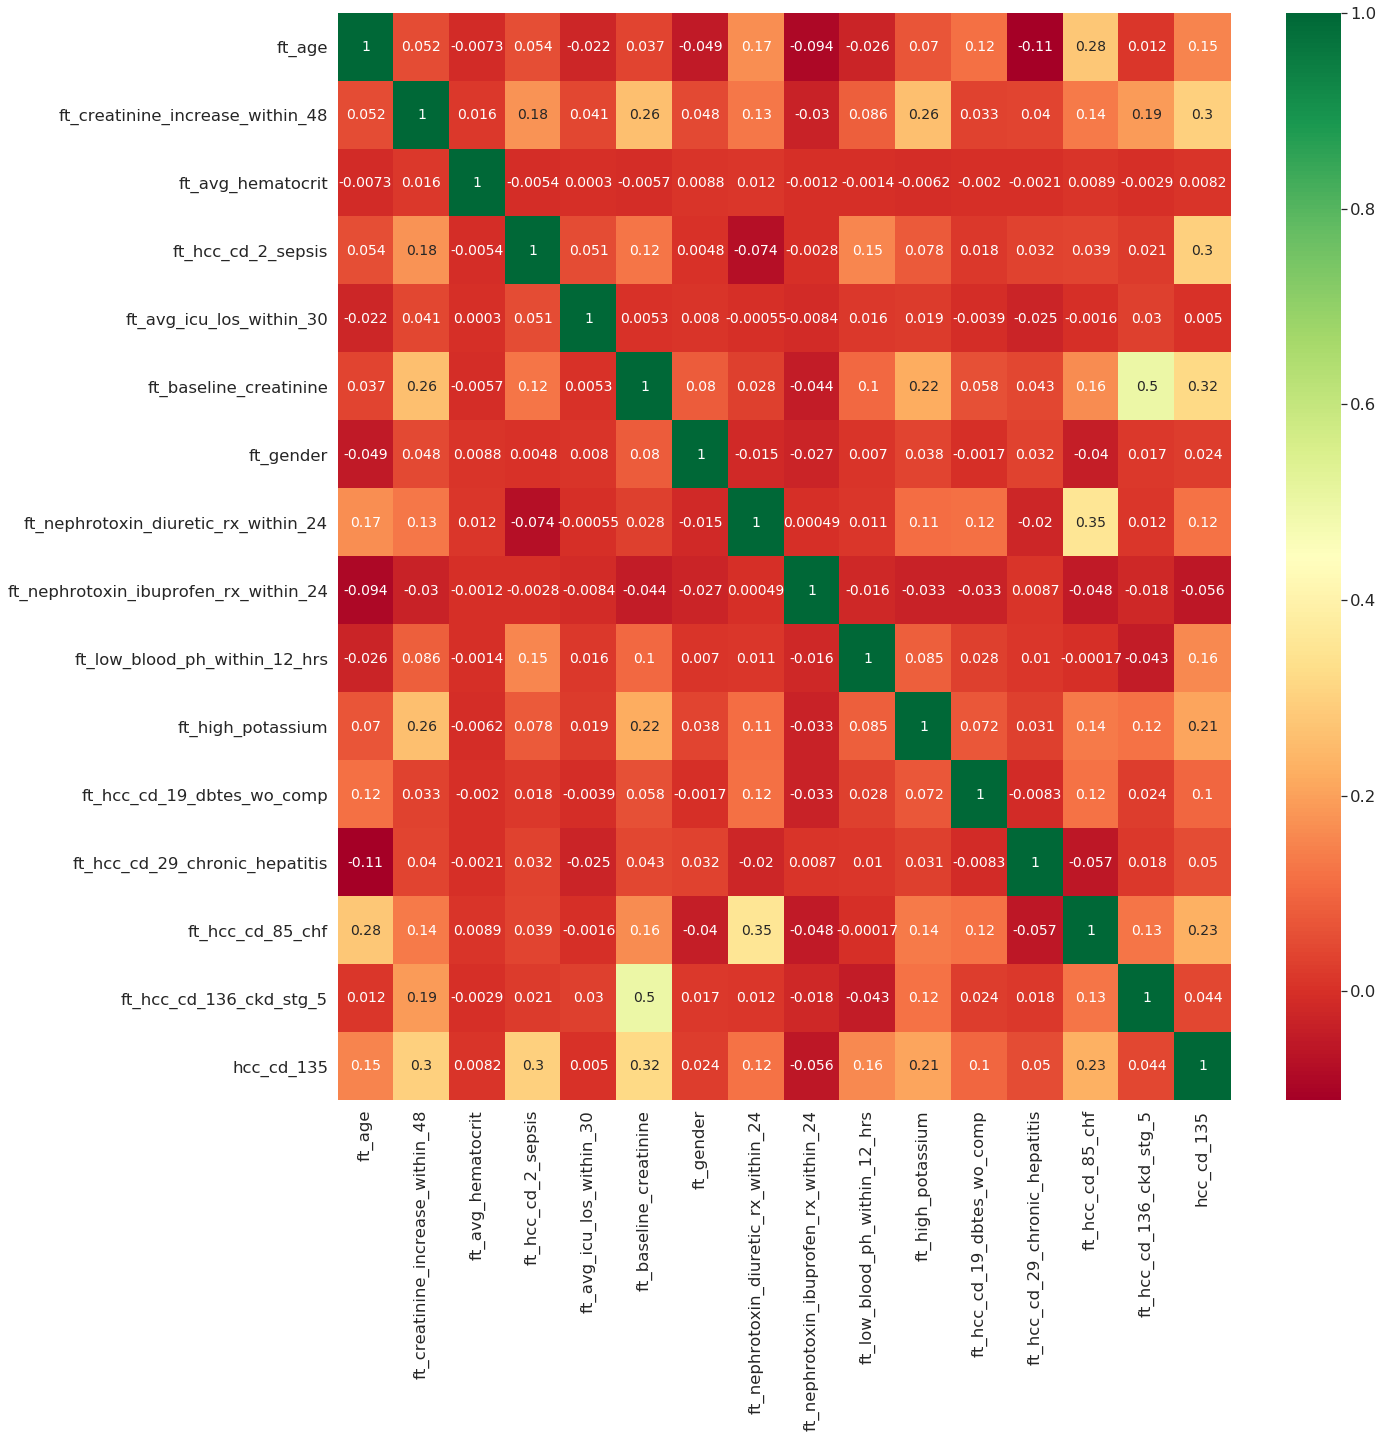

In [5]:
subs = data[lit_features + ['hcc_cd_135']]
corrmat = subs.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
sns.set(font_scale=1.5)
g = sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn", annot_kws={"size": 14})

In [6]:
lit_feature_importance = corrmat[['hcc_cd_135']]\
.drop('hcc_cd_135')\
.reset_index().rename(columns={'index': 'feature', 'hcc_cd_135': 'importance'})

### **Discussion**
It's interesting that not all the features that we see in this heatmap are linearly correlated to the target even though they seem to be relevant based on the literature.

**Feature Selection #2: Using PCA (supervised/unsupervised)**
---

**PCA**
---
> Principal Component Analysis (PCA) is a linear dimensionality reduction technique that can be utilized for extracting  information from a high-dimensional space by projecting it into a lower-dimensional sub-space. It tries to preserve the essential parts that have more variation of the data and remove the non-essential parts with fewer variation.

In [7]:
def pca(n, data, features):
    pca = PCA(n)
    principal_comp = pca.fit_transform(data[features].values)
    principal_df = pd.DataFrame(principal_comp, columns=[f'pc_{i}' for i in range(len(pca.explained_variance_ratio_))])
    feature_explained_variance = pd.DataFrame.from_dict(dict(zip(principal_df.columns.tolist(), 
                                pca.explained_variance_ratio_.tolist())), 
                                orient='index', columns=['variance'])
    return pca, principal_df, feature_explained_variance

def plot_pcs(components, target_variable, pc_a, pc_b):
    plt.figure()
    plt.figure(figsize=(10,10))
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=14)
    plt.xlabel(pc_a,fontsize=14)
    plt.ylabel(pc_b,fontsize=14)
    rcParams['figure.figsize'] = 11.7,8.27
    targets = [0, 1]
    colors = ['g', 'b']
    for target, color in zip(targets,colors):
        idx = target_variable == target
        plt.scatter(components.loc[idx, pc_a], 
                    components.loc[idx, pc_b], c=color, s=6)

    plt.legend(targets,prop={'size': 15})
    
def plot_3d(result, data):
    fig = plt.figure(figsize=(10,10))

    ax = Axes3D(fig) #<-- Note the difference from your original code...
    # ax = plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=result["pc_0"], 
        ys=result["pc_1"], 
        zs=result["pc_2"], 
        c=data["hcc_cd_135"], 
        cmap='tab10',
        s=5
    )
    ax.set_xlabel('pca-one')
    ax.set_ylabel('pca-two')
    ax.set_zlabel('pca-three')
    plt.show()


**PCA using literature features only**

In [8]:
pca_lit, principal_df, feature_explained_variance = pca(5, data, lit_features)
printer('principal components using just lit features')
principal_df.shape, data.shape
principal_df.head()
printer('feature explained variance using just lit features')
feature_explained_variance

principal components using just lit features
-------------------


((16058, 5), (16058, 198))

,pc_0,pc_1,pc_2,pc_3,pc_4
0,3.6430,3.0962,-1.0330,-0.8515,0.3180
1,1.2755,1.6776,-2.5296,-1.3227,-0.7941
2,-1.0795,0.9476,-0.3994,0.4335,0.6213
3,-1.3899,-0.3048,-0.5834,-0.2461,0.9751
4,-0.6727,-1.5585,-0.5723,-0.6830,-0.3636


feature explained variance using just lit features
-------------------


,variance
pc_0,0.1392
pc_1,0.1001
pc_2,0.0789
pc_3,0.0704
pc_4,0.0686


<Figure size 432x288 with 0 Axes>

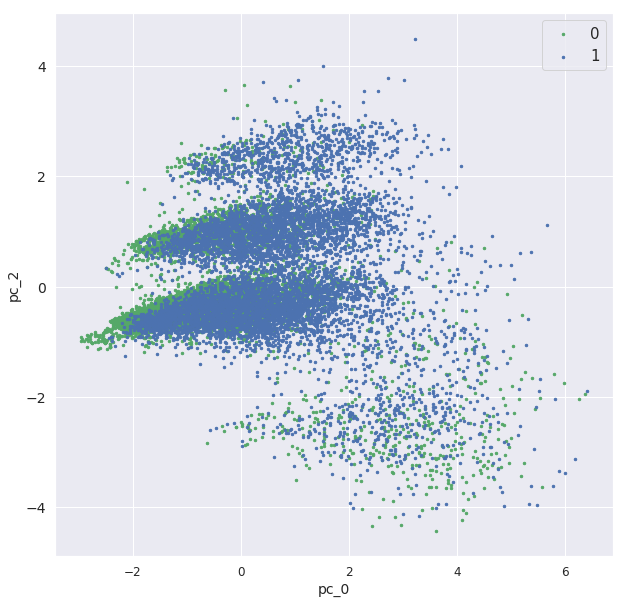

In [9]:
pca_supervised_data = principal_df.copy(deep=True)
plot_pcs(principal_df, data['hcc_cd_135'].reset_index(drop=True), 'pc_0', 'pc_2')

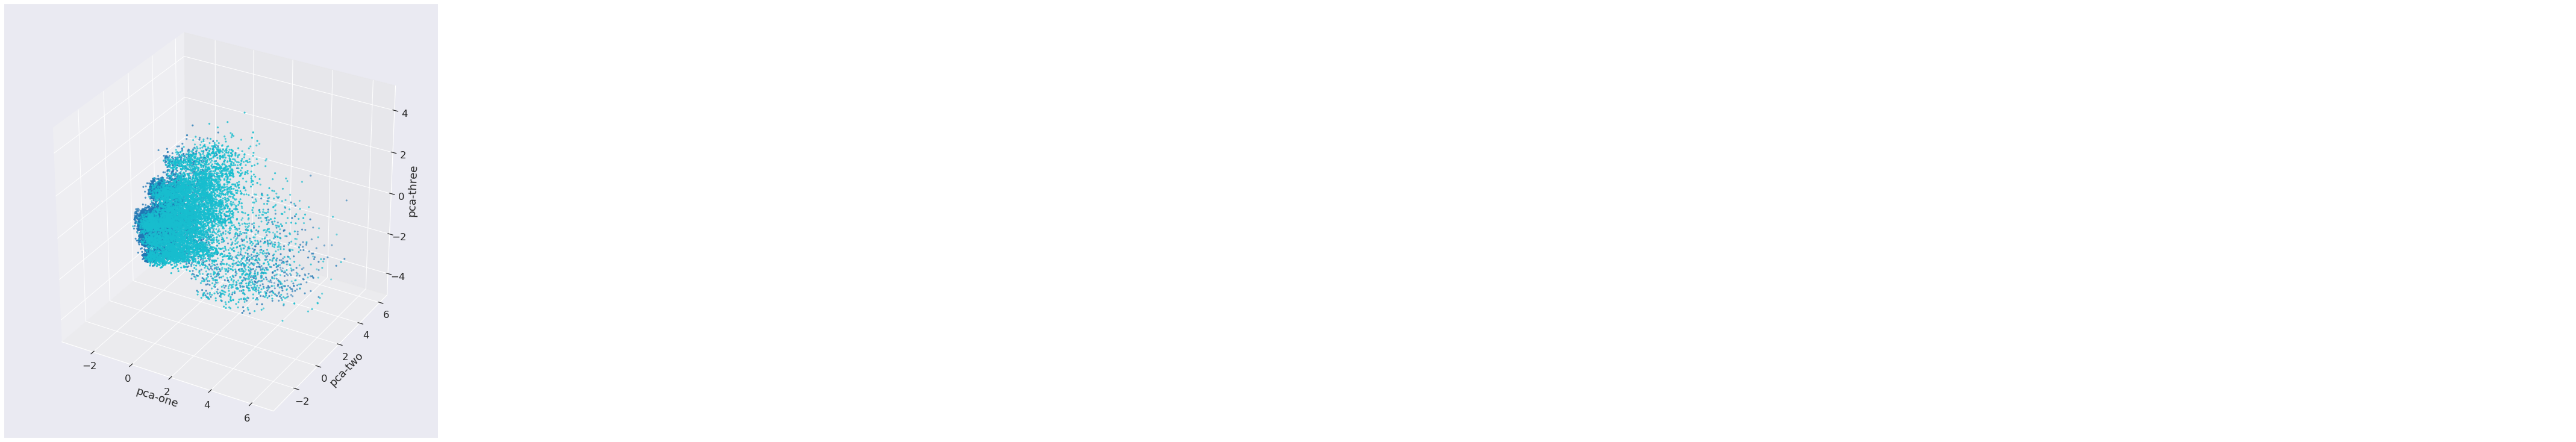

In [10]:
plot_3d(principal_df, data)

**PCA using all the features in the dataset**

In [11]:
all_features = [x for x in data if 'ft_' in x]
pca_all, principal_df, feature_explained_variance = pca(5, data, all_features)
printer('principal components using all features')
principal_df.shape, data.shape
principal_df.head()
printer('feature explained variance using all features')
feature_explained_variance

principal components using all features
-------------------


((16058, 5), (16058, 198))

,pc_0,pc_1,pc_2,pc_3,pc_4
0,-0.0684,7.7873,-7.6723,1.7308,-0.6898
1,3.9161,1.9511,-2.7766,0.7338,-0.1680
2,-6.2008,0.8808,1.6234,-1.8029,0.6062
3,3.4093,1.5810,1.9918,-0.8492,0.2287
4,1.0028,-1.1348,-2.4247,0.5759,-0.1563


feature explained variance using all features
-------------------


,variance
pc_0,0.0579
pc_1,0.0435
pc_2,0.0369
pc_3,0.0338
pc_4,0.0319


<Figure size 842.4x595.44 with 0 Axes>

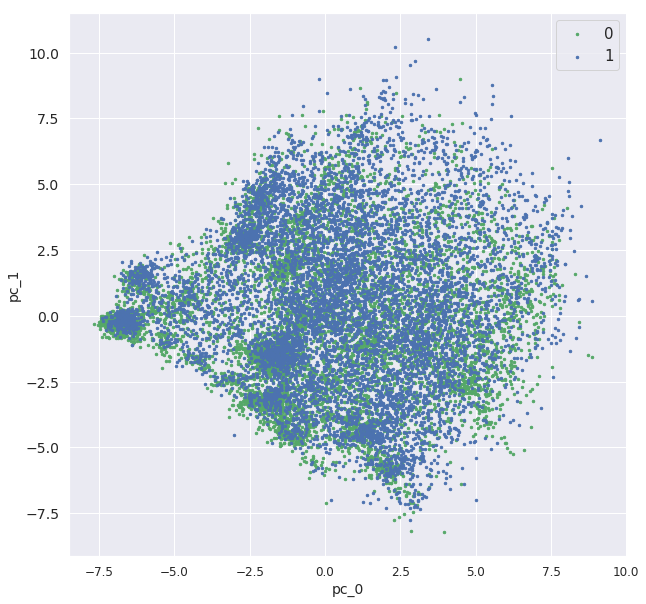

In [12]:
pca_unsupervised_data = principal_df.copy(deep=True)
plot_pcs(principal_df, data['hcc_cd_135'].reset_index(drop=True), 'pc_0', 'pc_1')

In [13]:
explained_variances = []

for i in range(5,10):
    _, _, variance = pca(i, data, all_features)
    explained_variances.append(variance.T)
    
explained_variances = pd.concat(explained_variances, ignore_index=True, sort=False)
explained_variances['N'] = range(5,10)
explained_variances

,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,pc_7,pc_8,N
0,0.0579,0.0435,0.0369,0.0338,0.0319,nan,nan,nan,nan,5
1,0.0579,0.0435,0.0369,0.0338,0.0319,0.0246,nan,nan,nan,6
2,0.0579,0.0435,0.0369,0.0338,0.0319,0.0246,0.0237,nan,nan,7
3,0.0579,0.0435,0.0369,0.0338,0.0319,0.0246,0.0237,0.0230,nan,8
4,0.0579,0.0435,0.0369,0.0338,0.0319,0.0246,0.0237,0.0230,0.0207,9


### **Discussion**
- PCA doesn't seem to be successful. Either we don't have enough information in our feature engineering set to sufficiently predict AKI or we are missing something.
- PCA also doesn't seem to totally work on the "one-hot" encoded variables that we have in this dataset. We may consider doing MCA instead.
- Also number of components provided to the PCA doesn't change the explained ratio of each feature. As we add components, we add the percentage of variance in the original graph explained by that variable.

**Feature Selection #3: Select K Best**
---
For this it is important to use **unscaled** data and **drop** any fields which might have negative values.

In [14]:
def score_features(data, label, features=None, n=25):
    if not features:
        features = data.drop(label, axis=1).columns.tolist()
        
    best_features = SelectKBest(score_func=chi2, k=n) # ok for binary data
    X, y = data[features].values, data[label].values
    fit = best_features.fit(X,y)
    
    df_scores = pd.DataFrame(fit.scores_)
    df_columns = pd.DataFrame(features)

    featureScores = pd.concat([df_columns, df_scores],axis=1)
    featureScores.columns = ['feature','importance'] 
    return featureScores.nlargest(n, 'importance')

In [15]:
select_k_best = score_features(data_no_scaled.drop(['ft_avg_creatinine', 'ft_baseline_creatinine'], axis=1), 'hcc_cd_135')
select_k_best

,feature,importance
48,ft_avg_hematocrit,17997.1451
47,ft_baseline_creat_gt_1,1742.4871
0,ft_age,1471.3876
190,ft_hcc_cd_2_sepsis,1150.2266
45,ft_creatinine_increase_within_48,1094.8855
46,ft_creatinine_increase_from_baseline,635.1390
2,ft_admit_type_elective,574.1123
71,ft_hcc_cd_85_chf,532.5979
117,ft_nephrotoxin_antibiotics_rx_within_24,443.9599
118,ft_nephrotoxin_antibiotics_rx_within_48,430.8012


**Feature Selection #3: Decision Tree**
---
Use a decision tree to identify the most important features. Use the default settings on the tree. Also fit an optimized tree.

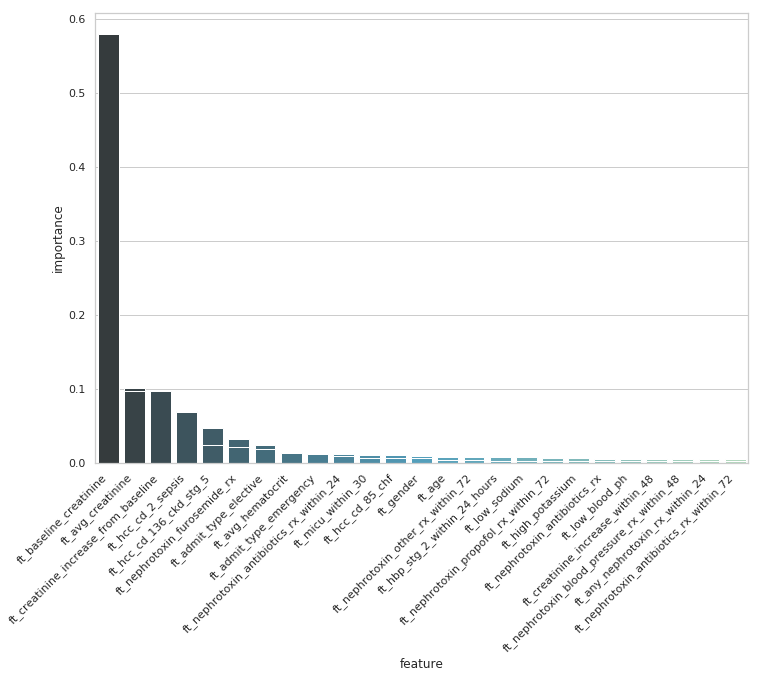

In [16]:
# fit the classifier
unrelated_features = [x for x in data if ('creat' not in x) and ('ft_' in x)]
features = [x for x in all_features if x in test and x in valid]
select_k_best_features = [x for x in select_k_best.feature.values.tolist() if x in test and x in valid]

X = data[features].values
y = data.hcc_cd_135

# baseline
baseline_decision_tree = DecisionTreeClassifier(criterion='entropy')
baseline_decision_tree = baseline_decision_tree.fit(X,y)

# optimized
optimized_decision_tree = DecisionTreeClassifier(criterion='entropy', 
                                                 min_samples_leaf=75,
                                                 min_samples_split=275)
optimized_decision_tree = optimized_decision_tree.fit(X,y)

# figure size in inches
def plot_feature_importance(classifier, features):
    feature_importance = pd.DataFrame({'feature': features, 
                                       'importance': classifier.feature_importances_})\
                            .sort_values('importance')\
                            .nlargest(25, 'importance')
    colors = sns.color_palette("GnBu_d", n_colors=len(feature_importance))
    rcParams['figure.figsize'] = 11.7,8.27
    sns.set(font_scale=1)
    sns.set_style("whitegrid")
    chart = sns.barplot(x='feature', y="importance", data=feature_importance, palette=colors)
    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=45, 
        horizontalalignment='right',
        fontweight='light'
    )
    return feature_importance

decision_feature_importance = plot_feature_importance(baseline_decision_tree, features)
final_decision_feature_importance = plot_feature_importance(optimized_decision_tree, features)

decision_tree_features = final_decision_feature_importance.feature.values.tolist()
X = data[decision_tree_features].values
y = data.hcc_cd_135

# optimized with select-k-best features
fully_optimized_decision_tree = DecisionTreeClassifier(criterion='entropy', 
                                                       min_samples_leaf=50,
                                                       min_samples_split=500)
fully_optimized_decision_tree = fully_optimized_decision_tree.fit(X,y)

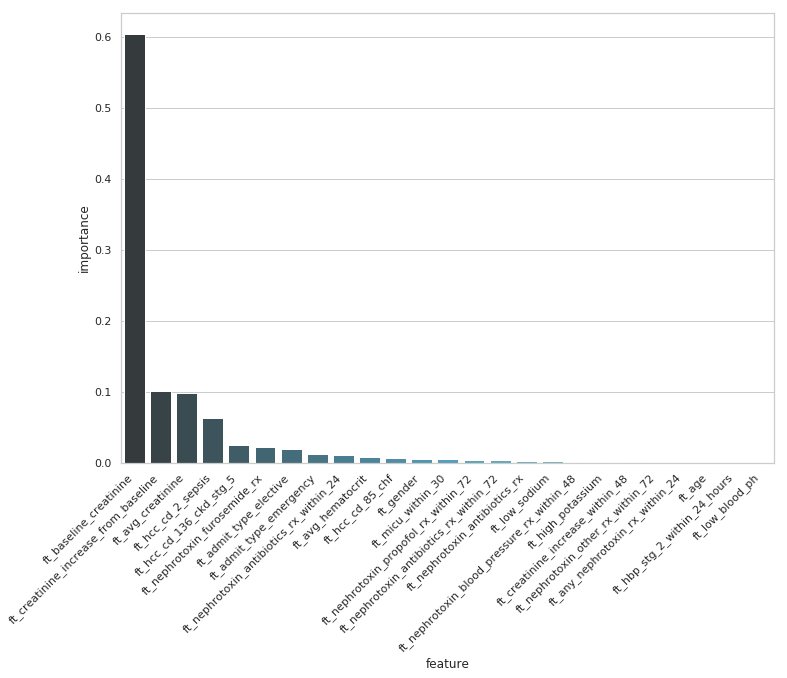

In [17]:
fully_optimized_decision_feature_importance = \
plot_feature_importance(fully_optimized_decision_tree, decision_tree_features)

**Selected Features**
---
Select the relevant feature sets to compare in the **logisitic regression** modelling. The default feature set will be used ase a baseline and for other models that we show here.

In [18]:
feature_set = [
    {'selection_type': 'baseline-logistic-regression',
     'data': data,
     'features': features},
    {'selection_type': 'log-reg-literature',
     'data': data,
     'features': lit_feature_importance.feature.values.tolist()},
    {'selection_type': 'log-reg-pca-supervised',
     'data': pd.concat([pca_supervised_data, data[['hcc_cd_135']].reset_index(drop=True)], axis=1),
     'features': pca_supervised_data.columns},
#     {'selection_type': 'pca-unsupervised',
#      'data': pd.concat([pca_unsupervised_data, data[['hcc_cd_135']].reset_index(drop=True)], axis=1),
#      'features': pca_unsupervised_data.columns},
    {'selection_type': 'log-reg-select-k-best',
     'data': data,
     'features': select_k_best.feature.values.tolist()},
    {'selection_type': 'log-reg-decision-tree',
     'data': data,
     'features': final_decision_feature_importance.feature.values.tolist()},
]

In [19]:
lp = []
for v in feature_set:
    selection, fts = v['selection_type'], v['features']
    if 'pca' in selection:
        continue
    res = pd.DataFrame.from_dict({selection: sorted(fts)}, 
                                 orient='index')\
                      .T\
                      .set_index(selection)
    res[selection] = 1
    lp.append(res)

import functools
lp = functools.reduce(lambda x,y: x.join(y, how='outer'), lp)
lp['used'] = lp.sum(axis=1)
lp.sort_values('used', ascending=False).fillna(' ').head(25)

,baseline-logistic-regression,log-reg-literature,log-reg-select-k-best,log-reg-decision-tree,used
ft_hcc_cd_85_chf,1,1.0000,1.0000,1.0000,4.0000
ft_high_potassium,1,1.0000,1.0000,1.0000,4.0000
ft_age,1,1.0000,1.0000,1.0000,4.0000
ft_creatinine_increase_within_48,1,1.0000,1.0000,1.0000,4.0000
ft_hcc_cd_2_sepsis,1,1.0000,1.0000,1.0000,4.0000
ft_avg_hematocrit,1,1.0000,1.0000,1.0000,4.0000
ft_baseline_creatinine,1,1.0000,,1.0000,3.0000
ft_hcc_cd_136_ckd_stg_5,1,1.0000,,1.0000,3.0000
ft_low_blood_ph_within_12_hrs,1,1.0000,1.0000,,3.0000
ft_nephrotoxin_antibiotics_rx_within_24,1,,1.0000,1.0000,3.0000


**Modeling**
---

In [20]:
models = []

### **Utility Functions**

In [21]:
from sklearn import metrics

def get_metrics(X, y, clf, clf_name):
    printer(f'\nmetrics for {clf_name}')
    y_score = clf.predict_proba(X)
    y_pred = clf.predict(X)
    fpr, tpr, _ = metrics.roc_curve(y, [i[1] for i in y_score])
    auc = metrics.auc(fpr, tpr)
    precision = metrics.precision_score(y, y_pred)
    recall = metrics.recall_score(y, y_pred)
    
    print(f'auc: {auc}\nprecision: {precision}\nrecall: {recall}')
    return [fpr, tpr, auc, precision, recall, clf_name]

def plot_roc(models, title):      
    sns.set_style("whitegrid")
    plt.figure(figsize=(20,10), facecolor='white')
    colors = ['slategrey', 
              'lightsteelblue', 
              'cornflowerblue',
              'royalblue', 
              'lavender', 
              'midnightblue', 
              'mediumslateblue', 
              'rebeccapurple',
             'plum']
    for c, m in zip(colors, models):
        fpr, tpr, auc, precision, recall, name = m
        plt.plot(fpr, tpr, color=c, lw=2, label=f'{name} auc:{round(auc,4)}') 
        plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
        
    SMALL_SIZE = 14
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title    
    
    plt.xlim([0.0, 1.02])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    plt.title(title, fontsize=22)
    plt.legend(loc="lower right")
    plt.show()

### **Run models on validation set to compare metrics**

In [22]:
res = get_metrics(X=valid[features].values,
                  y=valid['hcc_cd_135'].values,
                  clf=baseline_decision_tree,
                  clf_name='baseline-decision-tree')
models.append(res)


metrics for baseline-decision-tree
-------------------
auc: 0.7524950660332468
precision: 0.7491166077738516
recall: 0.7541129390840373


In [23]:
res = get_metrics(X=valid[features].values,
                  y=valid['hcc_cd_135'].values,
                  clf=optimized_decision_tree,
                  clf_name='optimized-decision-tree')
models.append(res)


metrics for optimized-decision-tree
-------------------
auc: 0.8967907764074481
precision: 0.8147505422993493
recall: 0.8350377945753669


In [24]:
res = get_metrics(X=valid[decision_tree_features].values,
                  y=valid['hcc_cd_135'].values,
                  clf=fully_optimized_decision_tree,
                  clf_name='optimized-decision-tree-with-top-25-features')
models.append(res)


metrics for optimized-decision-tree-with-top-25-features
-------------------
auc: 0.892871295624566
precision: 0.8236877523553163
recall: 0.8163628279235216


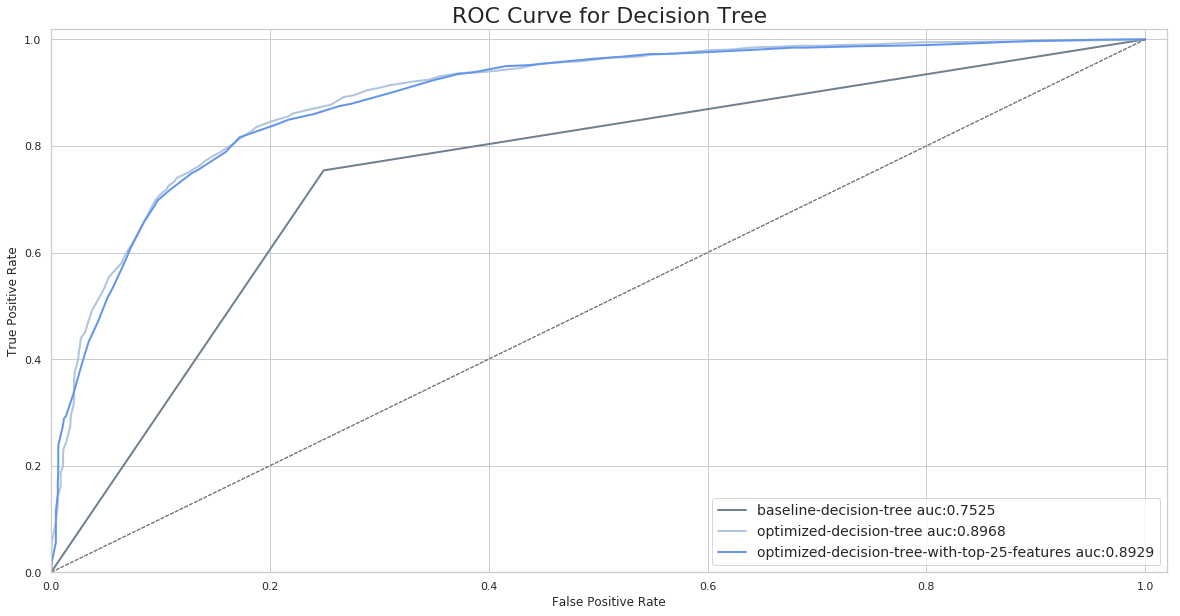

In [25]:
plot_roc(models, title='ROC Curve for Decision Tree')

**Logistic Regression**
---

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

def logistic_regression(data, valid, features, selection):
    lreg = LogisticRegression(solver='saga')
    X = data[features].values
    y = data['hcc_cd_135'].values
    lreg = lreg.fit(X,y)

    res = get_metrics(X=valid[features].values,
                      y=valid['hcc_cd_135'].values,
                      clf=lreg,
                      clf_name=selection)
    return res

In [27]:
log_reg_models = []
for i in feature_set:
    
    # edit the data used to be the validation set
    selection, data, fts = i['selection_type'], i['data'], i['features']
    if 'pca-supervised' in selection:
        val_sub = pd.DataFrame(pca_lit.transform(valid[lit_features]))
        val_sub.columns = [f'pc_{i}' for i in range(0, 5)]
        val_sub = pd.concat([val_sub, valid[['hcc_cd_135']]], axis=1)
    elif 'pca-unsupervised' in selection:
        continue
    else:
        val_sub = valid.copy(deep=True)
        
    # perform the logistic regression
    res = logistic_regression(data, val_sub, fts, selection)
    log_reg_models.append(res)
    print('\n')

/Users/lpanda/miniconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



metrics for baseline-logistic-regression
-------------------
auc: 0.8843289025141778
precision: 0.7905491698595147
recall: 0.8257003112494442



metrics for log-reg-literature
-------------------
auc: 0.8239463153214295
precision: 0.7736030828516378
recall: 0.7140951534015118



metrics for log-reg-pca-supervised
-------------------
auc: 0.7764021826464783
precision: 0.7141504969238051
recall: 0.670964873277012




/Users/lpanda/miniconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)



metrics for log-reg-select-k-best
-------------------
auc: 0.865082824335182
precision: 0.7639000805801772
recall: 0.8430413517118719



metrics for log-reg-decision-tree
-------------------
auc: 0.8491417238070722
precision: 0.7888631090487239
recall: 0.755891507336594




/Users/lpanda/miniconda3/envs/ds/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


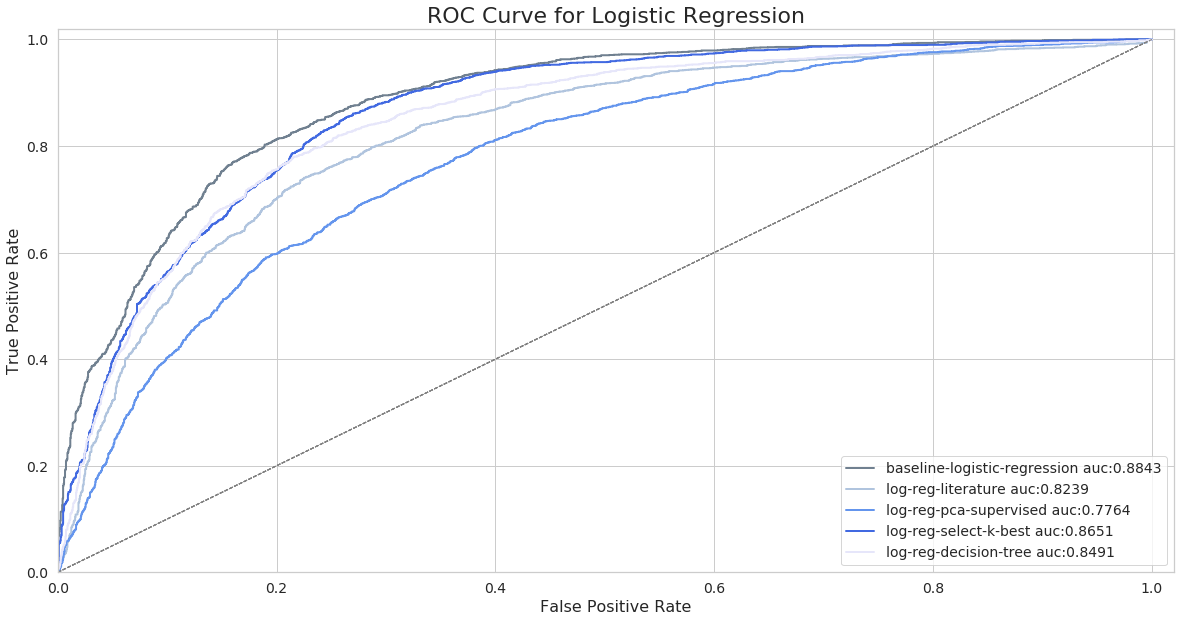

In [28]:
plot_roc(log_reg_models, 'ROC Curve for Logistic Regression')

In [29]:
def make_table(models):
    ds = []
    for i in models:
        ds.append({'label': i[5],
                  'auc': i[2],
                  'precision': i[3],
                  'recall': i[4]})
    return pd.DataFrame.from_records(ds)

models += log_reg_models
make_table(models).sort_values(by=['auc', 'precision'], ascending=False)

,label,auc,precision,recall
1,optimized-decision-tree,0.8968,0.8148,0.8350
2,optimized-decision-tree-with-top-25-features,0.8929,0.8237,0.8164
3,baseline-logistic-regression,0.8843,0.7905,0.8257
6,log-reg-select-k-best,0.8651,0.7639,0.8430
7,log-reg-decision-tree,0.8491,0.7889,0.7559
4,log-reg-literature,0.8239,0.7736,0.7141
5,log-reg-pca-supervised,0.7764,0.7142,0.6710
0,baseline-decision-tree,0.7525,0.7491,0.7541


**Discussion**

The default logistic regression on all of the features performed better than any logistic regression with a subset of features and performed the same as the decision tree with the top 25 features.

In [30]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
pipe = Pipeline([('classifier' , RandomForestClassifier())])

param_grid = [
    {'classifier' : [LogisticRegression()],
     'classifier__penalty' : ['l2', 'l1'],
     'classifier__C' : np.logspace(-4, 4, 20),
     'classifier__solver' : ['liblinear']}
]
clf = GridSearchCV(pipe, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  7.0min finished



metrics for grid-searched-log-reg
-------------------
auc: 0.8845364021436428
precision: 0.7889830508474577
recall: 0.82792352156514


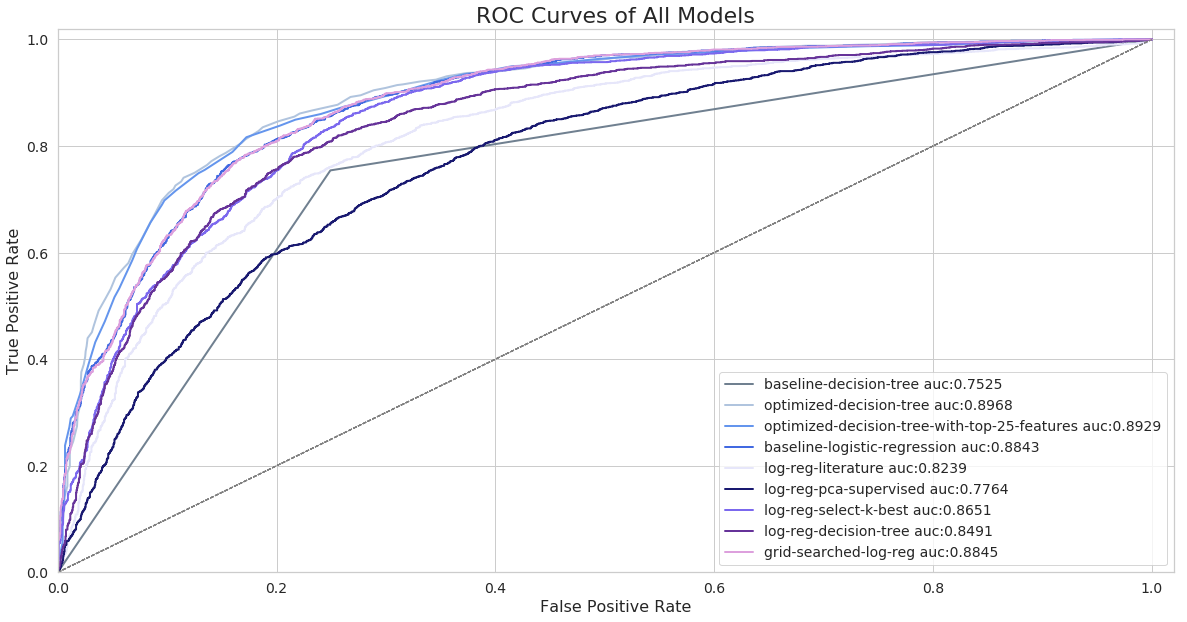

In [31]:
# Fit on data select k best feature set
lp = feature_set[0]
fts = lp['features']
X = lp['data'][fts].values
y = lp['data']['hcc_cd_135'].values
best_clf = clf.fit(X,y)

models_with_grid = models + [get_metrics(X=valid[fts].values,
                                         y=valid['hcc_cd_135'].values,
                                         clf=best_clf,
                                         clf_name='grid-searched-log-reg',)]
plot_roc(models_with_grid, 'ROC Curves of All Models')

In [32]:
make_table(models_with_grid).sort_values(by=['auc', 'precision'], ascending=False)

,label,auc,precision,recall
1,optimized-decision-tree,0.8968,0.8148,0.8350
2,optimized-decision-tree-with-top-25-features,0.8929,0.8237,0.8164
8,grid-searched-log-reg,0.8845,0.7890,0.8279
3,baseline-logistic-regression,0.8843,0.7905,0.8257
6,log-reg-select-k-best,0.8651,0.7639,0.8430
7,log-reg-decision-tree,0.8491,0.7889,0.7559
4,log-reg-literature,0.8239,0.7736,0.7141
5,log-reg-pca-supervised,0.7764,0.7142,0.6710
0,baseline-decision-tree,0.7525,0.7491,0.7541


In [47]:
from copy import deepcopy
all_models = deepcopy(models_with_grid)

def read_svm(path):
    return pd.read_csv(path, usecols=[1]).iloc[:, 0].values

svm_models = [[read_svm('svm_bl_fpr.csv'), read_svm('svm_bl_tpr.csv'), 0.85690, 0.80227, 0.75233, 'svm-top-25-features'],
              [read_svm('svm_opt_fpr.csv'), read_svm('svm_opt_tpr.csv'), 0.856475, 0.80246, 0.7514, 'optimized-svm-top-25-features']]
all_models.extend(svm_models)
tbl = make_table(all_models).sort_values(by=['auc', 'precision'], ascending=False)
tbl

,label,auc,precision,recall
1,optimized-decision-tree,0.8968,0.8148,0.8350
2,optimized-decision-tree-with-top-25-features,0.8929,0.8237,0.8164
8,grid-searched-log-reg,0.8845,0.7890,0.8279
3,baseline-logistic-regression,0.8843,0.7905,0.8257
6,log-reg-select-k-best,0.8651,0.7639,0.8430
9,svm-top-25-features,0.8569,0.8023,0.7523
10,optimized-svm-top-25-features,0.8565,0.8025,0.7514
7,log-reg-decision-tree,0.8491,0.7889,0.7559
4,log-reg-literature,0.8239,0.7736,0.7141
5,log-reg-pca-supervised,0.7764,0.7142,0.6710


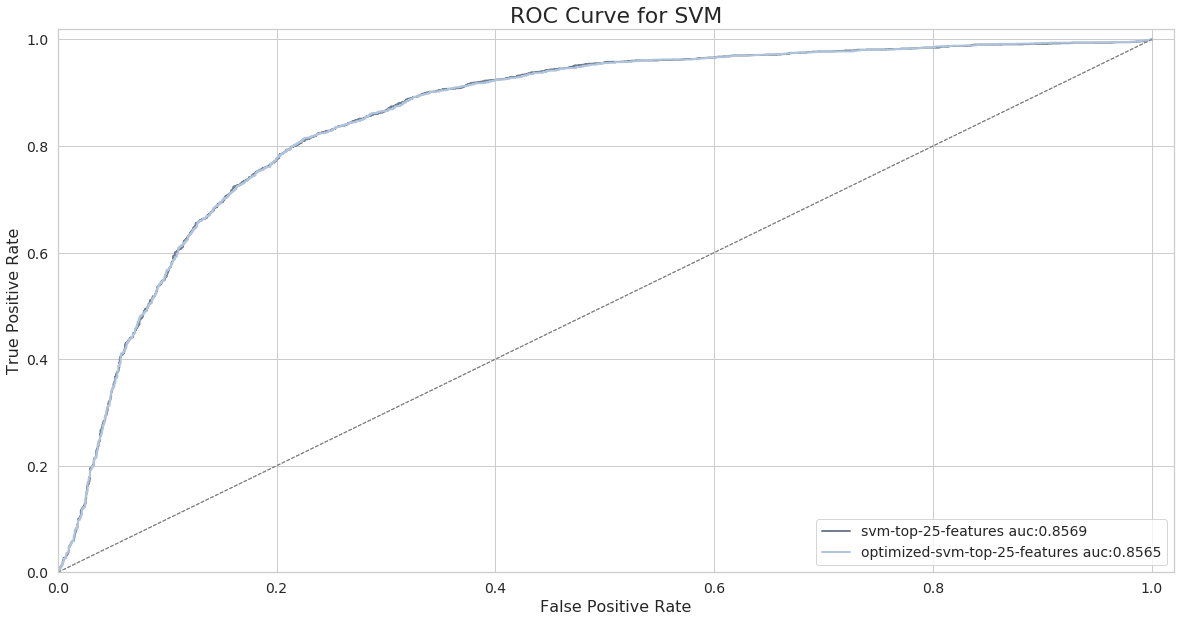

In [48]:
plot_roc(svm_models, 'ROC Curve for SVM')

In [34]:
fully_optimized_decision_feature_importance

,feature,importance
0,ft_baseline_creatinine,0.6040
2,ft_creatinine_increase_from_baseline,0.1015
1,ft_avg_creatinine,0.0982
3,ft_hcc_cd_2_sepsis,0.0629
4,ft_hcc_cd_136_ckd_stg_5,0.0255
5,ft_nephrotoxin_furosemide_rx,0.0224
6,ft_admit_type_elective,0.0189
8,ft_admit_type_emergency,0.0123
9,ft_nephrotoxin_antibiotics_rx_within_24,0.0102
7,ft_avg_hematocrit,0.0080


In [35]:
pd.Series(lit_features).to_frame().rename(columns={0:'feature'})

,feature
0,ft_age
1,ft_creatinine_increase_within_48
2,ft_avg_hematocrit
3,ft_hcc_cd_2_sepsis
4,ft_avg_icu_los_within_30
5,ft_baseline_creatinine
6,ft_gender
7,ft_nephrotoxin_diuretic_rx_within_24
8,ft_nephrotoxin_ibuprofen_rx_within_24
9,ft_low_blood_ph_within_12_hrs


In [36]:
res = get_metrics(X=test[decision_tree_features].values,
                  y=test['hcc_cd_135'].values,
                  clf=fully_optimized_decision_tree,
                  clf_name='optimized-decision-tree-with-top-25-features')


metrics for optimized-decision-tree-with-top-25-features
-------------------
auc: 0.8949070952096015
precision: 0.8470806302131604
recall: 0.7899740708729472
